In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from transformers import GPT2Tokenizer
import torch

In [2]:
from dist_ir.executor import (
    CostModel,
    infer_types,
    PostTypeInferenceSimulator,
    Simulator,
    SequentialExecutor,
)
from dist_ir.importer import import_from_onnx
from dist_ir.ir import cpprint, Device, Topology, Value
from dist_ir.ir.type import Float32, Tensor
from dist_ir.transforms import gpt2_dhp_transform, filter_transform

In [3]:
MODEL_PATH = "/lfs/1/keshav2/gpt2/model.onnx"
NETWORK_BANDWIDTH_Gbps = 200

In [4]:
def to_numpy(x):
    if type(x) is not np.ndarray:
        x = x.detach().cpu().numpy() if x.requires_grad else x.cpu().numpy()
    return x

In [5]:
def simulate(
    function,
    input_data,
    topology,
    dp_degree,
    hp_degree,
    pp_degree,
    num_microbatches,
    filter_set=None,
):
    world_size = dp_degree * hp_degree * pp_degree
    for i in range(1, world_size + 1):
        topology.add_device("gpu")
        for j in range(0, i):
            if j == 0:
                topology.set_bandwidth(
                    topology.devices[i], topology.devices[j], NETWORK_BANDWIDTH_Gbps
                )
            else:
                topology.set_bandwidth(
                    topology.devices[i], topology.devices[j], NETWORK_BANDWIDTH_Gbps
                )
    function = gpt2_dhp_transform(
        function,
        dp_degree,
        hp_degree,
        pp_degree,
        topology.devices,
        num_microbatches,
    )
    ex = SequentialExecutor("numpy")
    function = ex.infer_types(function, input_data)
    input_types = (v.type for v in function.inputs)
    function, typed_input_values = filter_transform(function, filter_set)
    input_types = (v.type for v in typed_input_values)
    simulator = PostTypeInferenceSimulator(CostModel(topology))
    simulation = simulator.interpret(function, input_types)
    return simulation

In [6]:
def import_function_and_get_input_data(model_path, batch_size, default_device):
    function, input_data = import_from_onnx(
        model_path,
        name="GPT-2",
        default_device=default_device,
        parse_input_data=True,
    )

    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokens = tokenizer.encode(
        "Here is some text to encode Hello World", add_special_tokens=True
    )
    input_ids = torch.tensor([[tokens] for _ in range(batch_size)])
    input_ids = to_numpy(input_ids)

    inputs_with_shapes = [
        Value(
            function.inputs[0].name,
            Tensor(
                dtype=Float32(),
                shape=tuple(input_ids.shape),
                device=default_device,
            ),
        )
    ]
    inputs_with_shapes += list(input_data.keys())
    input_data = [input_ids] + list(input_data.values())
    return function, input_data

In [7]:
def get_simulation(batch_size, dp_degree, hp_degree, pp_degree, num_microbatches, filter_set=None):
    topology = Topology()
    d0 = topology.add_device("gpu")
    function, input_data = import_function_and_get_input_data(
        MODEL_PATH, batch_size=batch_size, default_device=d0
    )
    simulation = simulate(
        function,
        input_data,
        topology,
        dp_degree,
        hp_degree,
        pp_degree,
        num_microbatches,
        filter_set
    )
    return simulation, function

In [8]:
def plot_live_memory(simulation, start_time=0, figsize=(10, 8)):
    world_size = len(simulation.live_memory)
    fig, axs = plt.subplots(world_size, sharex=True, sharey=False, figsize=figsize)
    devices = sorted(simulation.live_memory.keys(), key=lambda x: int(x.device_id))
    for i, device in enumerate(devices):
        x, y = zip(*simulation.live_memory[device])
        live_memory = defaultdict(lambda: 0)
        for x_, y_ in zip(x, y):
            if x_ * 1e3 >= start_time:
                live_memory[x_ * 1e3] = max(live_memory[x_ * 1e3], y_)
        x = sorted(live_memory.keys())
        y = [live_memory[x_] / (2.0**20) for x_ in x]
        if world_size == 1:
            axs.plot(x, y)
        else:
            axs[i].plot(x, y)
    plt.xlabel("Time (ms)")
    fig.text(0.075, 0.5, "MiB", va="center", rotation="vertical")

In [9]:
simulation, function = get_simulation(64, 1, 1, 1, 1, filter_set=set(["Send"]))
simulation.dump_chrome_trace("gpt2_single_device.json")

Initial live memory on device 1: 522.7054138183594 MiB


In [10]:
per_input_sizes = []
for inp in function.inputs:
    per_input_sizes.append((inp, inp.type.size()))
per_input_sizes.sort(key=lambda x: x[1], reverse=True)
for (inp, size) in per_input_sizes[:100]:
    print(f"{inp}: {size / (2**20)} MiB")

Value(name='wte.weight', type=Tensor[shape=(50257, 768), dtype=Float32, device=0 (gpu)]): 147.2373046875 MiB
Value(name='h.0.mlp.c_fc.weight', type=Tensor[shape=(768, 3072), dtype=Float32, device=0 (gpu)]): 9.0 MiB
Value(name='h.0.mlp.c_proj.weight', type=Tensor[shape=(3072, 768), dtype=Float32, device=0 (gpu)]): 9.0 MiB
Value(name='h.1.mlp.c_fc.weight', type=Tensor[shape=(768, 3072), dtype=Float32, device=0 (gpu)]): 9.0 MiB
Value(name='h.1.mlp.c_proj.weight', type=Tensor[shape=(3072, 768), dtype=Float32, device=0 (gpu)]): 9.0 MiB
Value(name='h.10.mlp.c_fc.weight', type=Tensor[shape=(768, 3072), dtype=Float32, device=0 (gpu)]): 9.0 MiB
Value(name='h.10.mlp.c_proj.weight', type=Tensor[shape=(3072, 768), dtype=Float32, device=0 (gpu)]): 9.0 MiB
Value(name='h.11.mlp.c_fc.weight', type=Tensor[shape=(768, 3072), dtype=Float32, device=0 (gpu)]): 9.0 MiB
Value(name='h.11.mlp.c_proj.weight', type=Tensor[shape=(3072, 768), dtype=Float32, device=0 (gpu)]): 9.0 MiB
Value(name='h.2.mlp.c_fc.weight

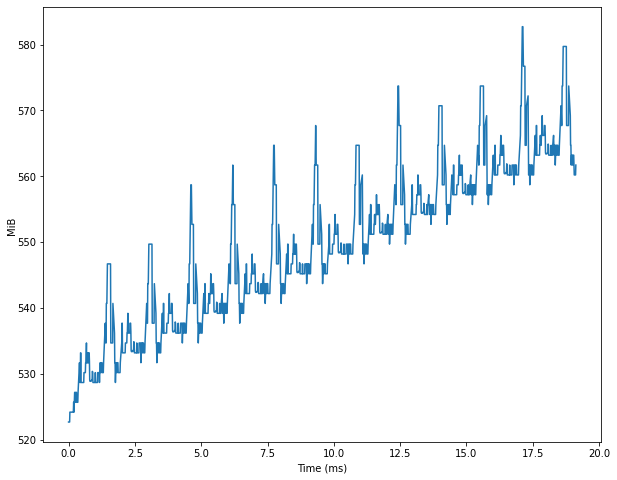

In [11]:
plot_live_memory(simulation)

In [12]:
simulation, function = get_simulation(64, 4, 1, 1, 1, filter_set=set(["Send", "MPIScatter", "MPIBroadcast"]))
simulation.dump_chrome_trace("gpt2_dp=4.json")

Initial live memory on device 1: 522.7024841308594 MiB
Initial live memory on device 2: 522.7024841308594 MiB
Initial live memory on device 3: 522.7024841308594 MiB
Initial live memory on device 4: 522.7024841308594 MiB


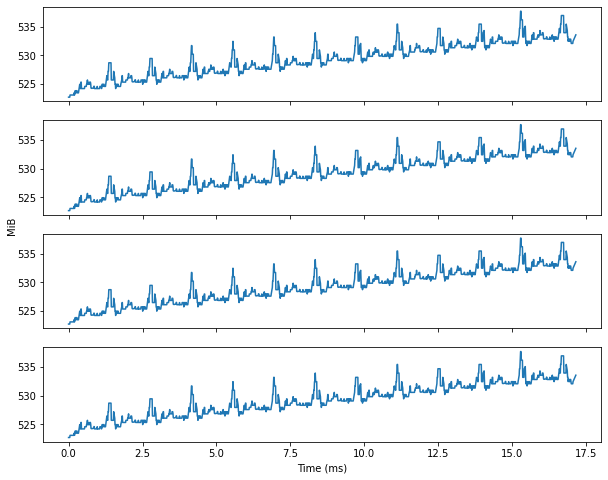

In [13]:
plot_live_memory(simulation)

In [14]:
simulation, function = get_simulation(64, 1, 1, 4, 4, filter_set=set(["Send"]))
simulation.dump_chrome_trace("gpt2_pp=4.json")

Initial live memory on device 1: 243.36167907714844 MiB
Initial live memory on device 2: 93.11457824707031 MiB
Initial live memory on device 3: 93.11457824707031 MiB
Initial live memory on device 4: 93.11457824707031 MiB


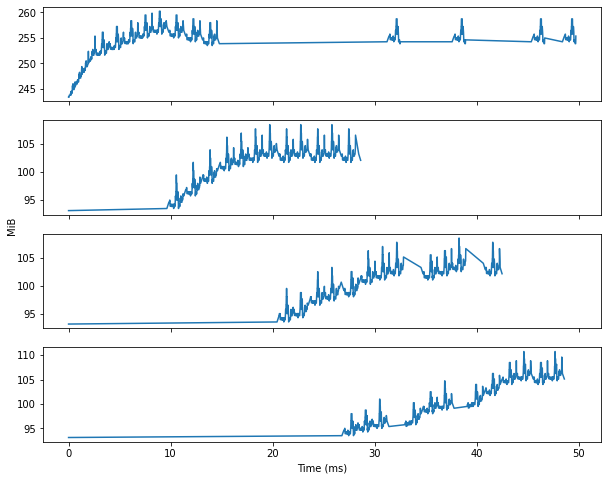

In [15]:
plot_live_memory(simulation)

In [16]:
simulation, function = get_simulation(64, 2, 1, 2, 4, filter_set=set(["Send", "MPIBroadcast", "MPIScatter"]))
simulation.dump_chrome_trace("gpt2_dp=2_pp=2.json")

Initial live memory on device 1: 336.47430419921875 MiB
Initial live memory on device 3: 336.47430419921875 MiB
Initial live memory on device 2: 186.22915649414062 MiB
Initial live memory on device 4: 186.22915649414062 MiB


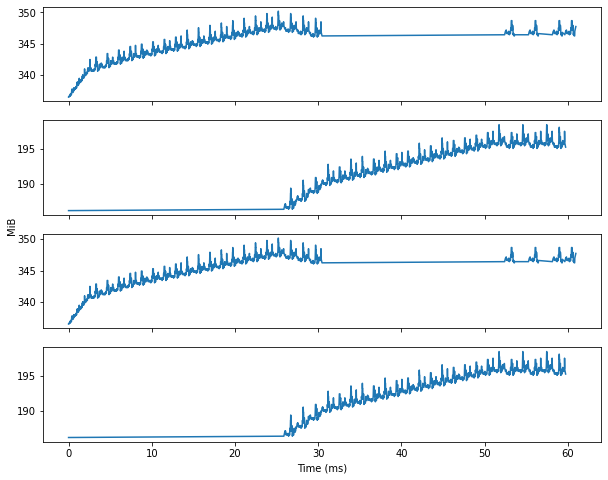

In [17]:
plot_live_memory(simulation)